Tensorboard on colab

In [1]:
import os
import requests
import shutil
import subprocess
import tensorflow as tf

__all__ = [
  'install_ngrok', 
  'launch_tensorboard',
]

def __shell__(cmd, split=True):
  # get_ipython().system_raw(cmd)
  result = get_ipython().getoutput(cmd, split=split)
  if result and not split:
    result = result.strip('\n')
  return result  


# tested OK
def install_ngrok(bin_dir="/tmp"):
  """ download and install ngrok on local vm instance
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
  """
  TARGET_DIR = bin_dir
  CWD = os.getcwd()
  is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
  if is_grok_avail:
    print("ngrok installed")
  else:
    import platform
    plat = platform.platform() # 'Linux-4.4.64+-x86_64-with-Ubuntu-17.10-artful'
    if 'x86_64' in plat:
      
      os.chdir('/tmp')
      print("calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ..." )
      get_ipython().system_raw( "wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip" )
      print("calling unzip ngrok-stable-linux-amd64.zip ...")
      get_ipython().system_raw( "unzip ngrok-stable-linux-amd64.zip" )
      os.rename("ngrok", "{}/ngrok".format(TARGET_DIR))
      os.remove("ngrok-stable-linux-amd64.zip")
      is_grok_avail = os.path.isfile(os.path.join(TARGET_DIR,'ngrok'))
      os.chdir(TARGET_DIR)
      if is_grok_avail:
        print("ngrok installed. path={}".format(os.path.join(TARGET_DIR,'ngrok')))
      else:
        # ValueError: ERROR: ngrok not found, path=
        raise ValueError( "ERROR: ngrok not found, path=".format(TARGET_DIR) )
    else:
      raise NotImplementedError( "ERROR, ngrok install not configured for this platform, platform={}".format(plat))
    os.chdir(CWD)
    return
    
# tested OK
def launch_tensorboard(bin_dir="/tmp", log_dir="/tmp", retval=False):
  """returns a public tensorboard url based on the ngrok package
  checks if `ngrok` is available, and installs, if necessary, to `bin_dir`
  launches tensorboard, if necessary
  see: https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab
  Args:
    bin_dir: full path for the target directory for the `ngrok` binary
    log_dir: full path for the tensorflow `log_dir`
  Return:
    public url for tensorboard if retval==True
      NOTE: the method will print a link to stdout (cell output) for the tensorflow URL. 
      But the link printed from the return value has an extra "%27" in the URL which causes an error
  """
  install_ngrok(bin_dir)
    
  if not tf.gfile.Exists(log_dir):  tf.gfile.MakeDirs(log_dir)
  
  # check status of tensorboard and ngrok
  ps = __shell__("ps -ax")
  is_tensorboard_running = len([f for f in ps if "tensorboard" in f ]) > 0
  is_ngrok_running = len([f for f in ps if "ngrok" in f ]) > 0
  print("status: tensorboard={}, ngrok={}".format(is_tensorboard_running, is_ngrok_running))

  if not is_tensorboard_running:
    get_ipython().system_raw(
        'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
        .format(log_dir)
    )
    is_tensorboard_running = True
    
  if not is_ngrok_running:  
    #    grok should be installed in /tmp/ngrok
    get_ipython().system_raw('{}/ngrok http 6006 &'.format(bin_dir))
    is_ngrok_running = True

  # get tensorboard url
  # BUG: getting connection refused for HTTPConnectionPool(host='localhost', port=4040)
  #     on first run, retry works
  import time
  time.sleep(3)
  retval = requests.get('http://localhost:4040/api/tunnels')
  tensorboard_url = retval.json()['tunnels'][0]['public_url'].strip()
  print("tensorboard url=", tensorboard_url)
  if retval:
    return tensorboard_url
  
# set paths
ROOT = %pwd
LOG_DIR = os.path.join(ROOT, 'log')

# will install `ngrok`, if necessary
# will create `log_dir` if path does not exist
launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

ngrok installed
status: tensorboard=True, ngrok=True
tensorboard url= http://343c3279.ngrok.io


'http://343c3279.ngrok.io'

Import libraries

In [2]:
# https://keras.io/
!pip install -q keras
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import cifar10 
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras.callbacks import TensorBoard

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


Load cifar10 images

In [0]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [0]:
im_shape = x_train[0].shape

Normalise

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format

Add Noise

In [0]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Preview

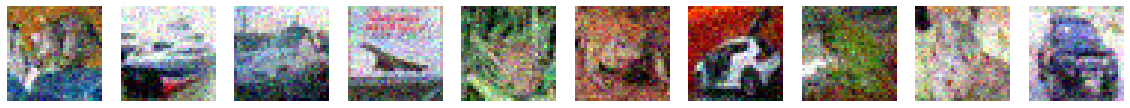

In [7]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(im_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
input_img = Input(shape=im_shape)  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [10]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False)])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5820 - val_loss: 0.5786
Epoch 2/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5765 - val_loss: 0.5857
Epoch 3/100
19584/50000 [==========>...................] - ETA: 6s - loss: 0.5740

50000/50000 [==============================] - 12s 238us/step - loss: 0.5734 - val_loss: 0.5746
Epoch 4/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5710 - val_loss: 0.5700
Epoch 5/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5696 - val_loss: 0.5688
Epoch 6/100
  384/50000 [..............................] - ETA: 11s - loss: 0.5674

50000/50000 [==============================] - 12s 241us/step - loss: 0.5683 - val_loss: 0.5661
Epoch 7/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5674 - val_loss: 0.5680
Epoch 8/100
45952/50000 [==========================>...] - ETA: 0s - loss: 0.5670

50000/50000 [==============================] - 12s 240us/step - loss: 0.5669 - val_loss: 0.5681
Epoch 9/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5661 - val_loss: 0.5666
Epoch 10/100
50000/50000 [==============================] - 12s 237us/step - loss: 0.5657 - val_loss: 0.5656
Epoch 11/100
 4992/50000 [=>............................] - ETA: 10s - loss: 0.5656

50000/50000 [==============================] - 12s 239us/step - loss: 0.5651 - val_loss: 0.5656
Epoch 12/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5647 - val_loss: 0.5649
Epoch 13/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5646

50000/50000 [==============================] - 12s 238us/step - loss: 0.5645 - val_loss: 0.5664
Epoch 14/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5642 - val_loss: 0.5654
Epoch 15/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5637 - val_loss: 0.5637
Epoch 16/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5622

50000/50000 [==============================] - 12s 239us/step - loss: 0.5633 - val_loss: 0.5650
Epoch 17/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5631 - val_loss: 0.5626
Epoch 18/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5629

50000/50000 [==============================] - 12s 238us/step - loss: 0.5627 - val_loss: 0.5640
Epoch 19/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5626 - val_loss: 0.5619
Epoch 20/100
50000/50000 [==============================] - 12s 237us/step - loss: 0.5623 - val_loss: 0.5632
Epoch 21/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5620

50000/50000 [==============================] - 12s 239us/step - loss: 0.5622 - val_loss: 0.5626
Epoch 22/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5621 - val_loss: 0.5631
Epoch 23/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5621

50000/50000 [==============================] - 12s 238us/step - loss: 0.5620 - val_loss: 0.5634
Epoch 24/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5617 - val_loss: 0.5621
Epoch 25/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5616 - val_loss: 0.5633
Epoch 26/100
 4480/50000 [=>............................] - ETA: 10s - loss: 0.5599

50000/50000 [==============================] - 12s 238us/step - loss: 0.5613 - val_loss: 0.5619
Epoch 27/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5612 - val_loss: 0.5620
Epoch 28/100
46464/50000 [==========================>...] - ETA: 0s - loss: 0.5610

50000/50000 [==============================] - 12s 239us/step - loss: 0.5610 - val_loss: 0.5614
Epoch 29/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5610 - val_loss: 0.5616
Epoch 30/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5609 - val_loss: 0.5608
Epoch 31/100
 4736/50000 [=>............................] - ETA: 9s - loss: 0.5604 

50000/50000 [==============================] - 12s 237us/step - loss: 0.5608 - val_loss: 0.5607
Epoch 32/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5608 - val_loss: 0.5616
Epoch 33/100
46464/50000 [==========================>...] - ETA: 0s - loss: 0.5608

50000/50000 [==============================] - 12s 238us/step - loss: 0.5608 - val_loss: 0.5610
Epoch 34/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5604 - val_loss: 0.5606
Epoch 35/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5602 - val_loss: 0.5620
Epoch 36/100
 4736/50000 [=>............................] - ETA: 9s - loss: 0.5586 

50000/50000 [==============================] - 12s 238us/step - loss: 0.5602 - val_loss: 0.5612
Epoch 37/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5602 - val_loss: 0.5600
Epoch 38/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5601

50000/50000 [==============================] - 12s 239us/step - loss: 0.5601 - val_loss: 0.5600
Epoch 39/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5601 - val_loss: 0.5608
Epoch 40/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5600 - val_loss: 0.5612
Epoch 41/100
 4480/50000 [=>............................] - ETA: 10s - loss: 0.5595

50000/50000 [==============================] - 12s 237us/step - loss: 0.5598 - val_loss: 0.5609
Epoch 42/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5596 - val_loss: 0.5614
Epoch 43/100
46464/50000 [==========================>...] - ETA: 0s - loss: 0.5596

50000/50000 [==============================] - 12s 239us/step - loss: 0.5596 - val_loss: 0.5601
Epoch 44/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5596 - val_loss: 0.5603
Epoch 45/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5595 - val_loss: 0.5596
Epoch 46/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5610

50000/50000 [==============================] - 12s 238us/step - loss: 0.5592 - val_loss: 0.5601
Epoch 47/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5594 - val_loss: 0.5598
Epoch 48/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5592

50000/50000 [==============================] - 12s 237us/step - loss: 0.5593 - val_loss: 0.5597
Epoch 49/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5593 - val_loss: 0.5600
Epoch 50/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5593 - val_loss: 0.5602
Epoch 51/100
 4736/50000 [=>............................] - ETA: 9s - loss: 0.5570 

50000/50000 [==============================] - 12s 237us/step - loss: 0.5588 - val_loss: 0.5589
Epoch 52/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5588 - val_loss: 0.5592
Epoch 53/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5588

50000/50000 [==============================] - 12s 239us/step - loss: 0.5589 - val_loss: 0.5595
Epoch 54/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5589 - val_loss: 0.5598
Epoch 55/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5589 - val_loss: 0.5595
Epoch 56/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5574

50000/50000 [==============================] - 12s 238us/step - loss: 0.5589 - val_loss: 0.5604
Epoch 57/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5588 - val_loss: 0.5598
Epoch 58/100
46464/50000 [==========================>...] - ETA: 0s - loss: 0.5590

50000/50000 [==============================] - 12s 238us/step - loss: 0.5589 - val_loss: 0.5589
Epoch 59/100
50000/50000 [==============================] - 12s 237us/step - loss: 0.5588 - val_loss: 0.5589
Epoch 60/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5587 - val_loss: 0.5588
Epoch 61/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5578

50000/50000 [==============================] - 12s 239us/step - loss: 0.5587 - val_loss: 0.5590
Epoch 62/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5587 - val_loss: 0.5605
Epoch 63/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5585

50000/50000 [==============================] - 12s 238us/step - loss: 0.5585 - val_loss: 0.5591
Epoch 64/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5584 - val_loss: 0.5591
Epoch 65/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5585 - val_loss: 0.5588
Epoch 66/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5599

50000/50000 [==============================] - 12s 238us/step - loss: 0.5583 - val_loss: 0.5600
Epoch 67/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5584 - val_loss: 0.5600
Epoch 68/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5582

50000/50000 [==============================] - 12s 238us/step - loss: 0.5584 - val_loss: 0.5584
Epoch 69/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5584 - val_loss: 0.5594
Epoch 70/100
50000/50000 [==============================] - 12s 241us/step - loss: 0.5584 - val_loss: 0.5586
Epoch 71/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5553

50000/50000 [==============================] - 12s 237us/step - loss: 0.5583 - val_loss: 0.5595
Epoch 72/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5582 - val_loss: 0.5586
Epoch 73/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5581

50000/50000 [==============================] - 12s 239us/step - loss: 0.5581 - val_loss: 0.5603
Epoch 74/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5581 - val_loss: 0.5606
Epoch 75/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5580 - val_loss: 0.5591
Epoch 76/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5576

50000/50000 [==============================] - 12s 241us/step - loss: 0.5580 - val_loss: 0.5584
Epoch 77/100
50000/50000 [==============================] - 12s 236us/step - loss: 0.5580 - val_loss: 0.5591
Epoch 78/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5580

50000/50000 [==============================] - 12s 238us/step - loss: 0.5579 - val_loss: 0.5593
Epoch 79/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5579 - val_loss: 0.5583
Epoch 80/100
50000/50000 [==============================] - 12s 239us/step - loss: 0.5580 - val_loss: 0.5612
Epoch 81/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5579

50000/50000 [==============================] - 12s 238us/step - loss: 0.5579 - val_loss: 0.5595
Epoch 82/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5579 - val_loss: 0.5584
Epoch 83/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5578

50000/50000 [==============================] - 12s 237us/step - loss: 0.5578 - val_loss: 0.5588
Epoch 84/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5578 - val_loss: 0.5576
Epoch 85/100
50000/50000 [==============================] - 12s 237us/step - loss: 0.5577 - val_loss: 0.5580
Epoch 86/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5586

50000/50000 [==============================] - 12s 238us/step - loss: 0.5578 - val_loss: 0.5593
Epoch 87/100
50000/50000 [==============================] - 12s 237us/step - loss: 0.5578 - val_loss: 0.5586
Epoch 88/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5578

50000/50000 [==============================] - 12s 237us/step - loss: 0.5578 - val_loss: 0.5589
Epoch 89/100
50000/50000 [==============================] - 12s 238us/step - loss: 0.5577 - val_loss: 0.5599
Epoch 90/100
50000/50000 [==============================] - 12s 241us/step - loss: 0.5578 - val_loss: 0.5587
Epoch 91/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5580

50000/50000 [==============================] - 12s 242us/step - loss: 0.5577 - val_loss: 0.5584
Epoch 92/100
50000/50000 [==============================] - 12s 241us/step - loss: 0.5575 - val_loss: 0.5591
Epoch 93/100
46720/50000 [===========================>..] - ETA: 0s - loss: 0.5576

50000/50000 [==============================] - 12s 240us/step - loss: 0.5576 - val_loss: 0.5587
Epoch 94/100
50000/50000 [==============================] - 12s 241us/step - loss: 0.5577 - val_loss: 0.5580
Epoch 95/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5576 - val_loss: 0.5585
Epoch 96/100
 4736/50000 [=>............................] - ETA: 10s - loss: 0.5570

50000/50000 [==============================] - 12s 240us/step - loss: 0.5576 - val_loss: 0.5580
Epoch 97/100
50000/50000 [==============================] - 12s 242us/step - loss: 0.5577 - val_loss: 0.5581
Epoch 98/100
46464/50000 [==========================>...] - ETA: 0s - loss: 0.5574

50000/50000 [==============================] - 12s 240us/step - loss: 0.5574 - val_loss: 0.5586
Epoch 99/100
50000/50000 [==============================] - 12s 243us/step - loss: 0.5576 - val_loss: 0.5582
Epoch 100/100
50000/50000 [==============================] - 12s 240us/step - loss: 0.5577 - val_loss: 0.5582


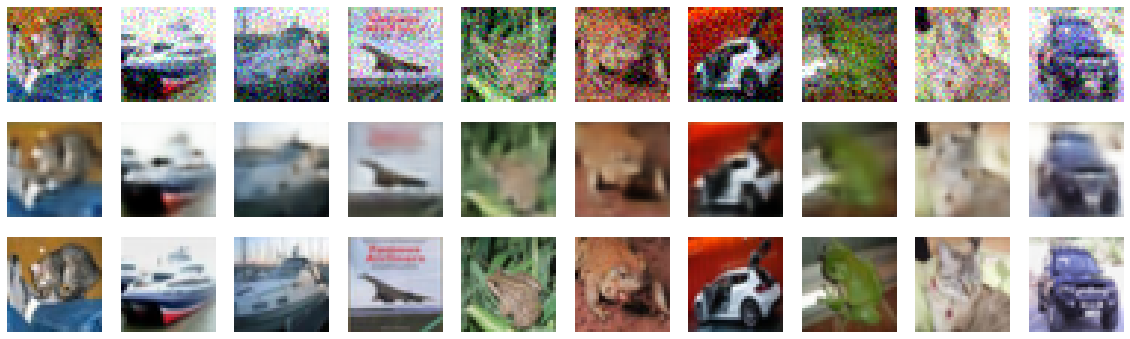

In [16]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display noisy
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(im_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(im_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i+2*n+1)
    plt.imshow(x_test[i].reshape(im_shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: ignored

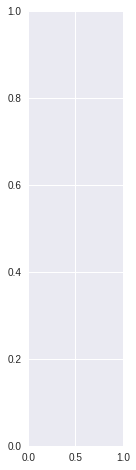

In [13]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()